In [1]:
import pandas as pd
import numpy as np
import data
import trade
import optimization as opt
import plot as pt
from matplotlib import pyplot as plt

In [2]:
df = data.get_data()
df = data.excess_return_unit(df)
df = data.exponential_moving_averages(df, col='SPY')
df = data.kelly_fraction(df, col='Excess Return')
df = data.moving_averages(df, col='SPY')
df = df.fillna(df['SPY'][0])

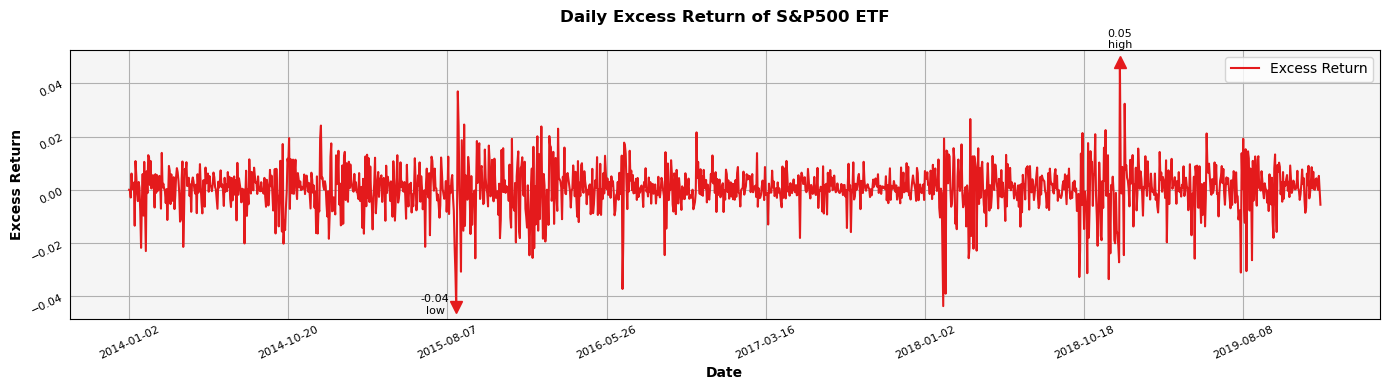

In [3]:
pt.plot_time_series_annotated(df=df, ylabel='Excess Return',x_col='Date', y_cols=['Excess Return'], title='Daily Excess Return of S&P500 ETF')

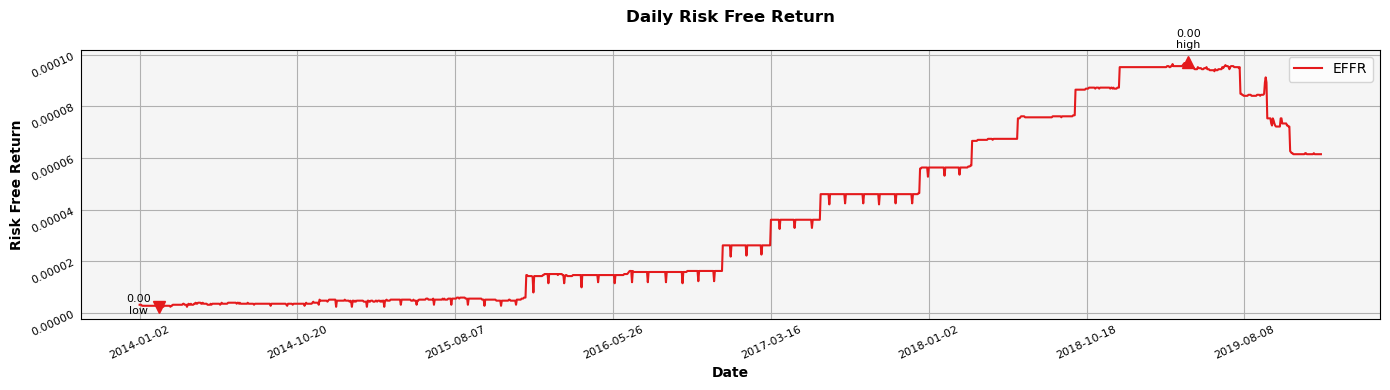

In [4]:
pt.plot_time_series_annotated(df=df, ylabel='Risk Free Return', x_col='Date', y_cols=['EFFR'], title='Daily Risk Free Return')

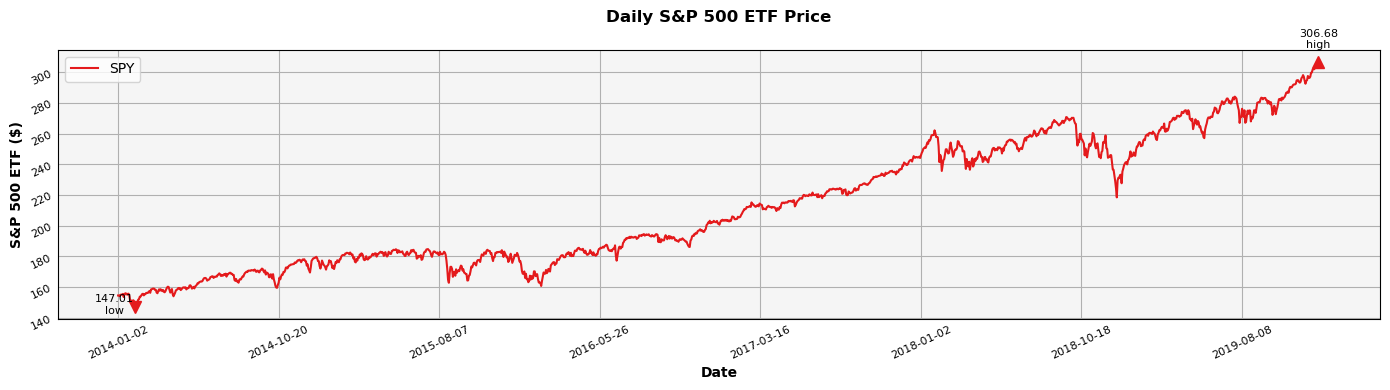

In [5]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['SPY'], title='Daily S&P 500 ETF Price')

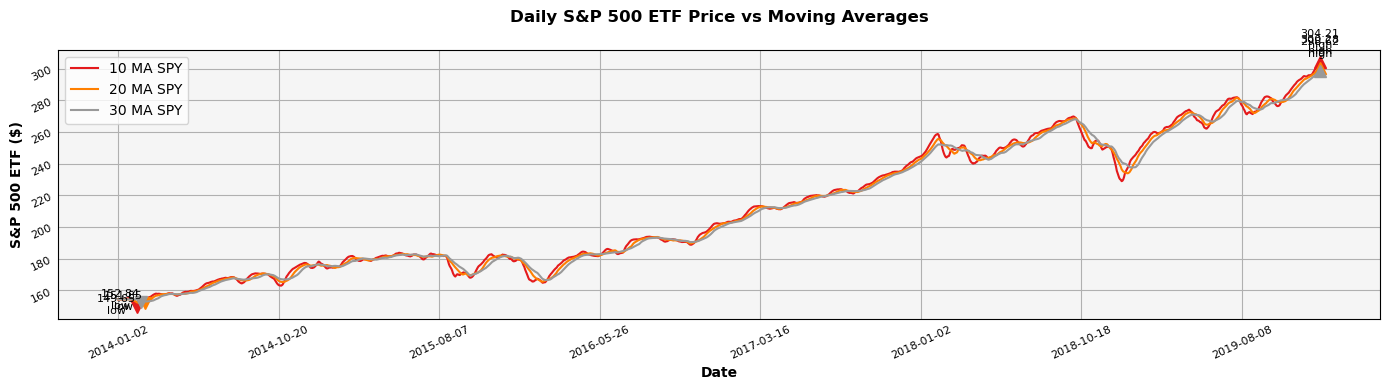

In [6]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10 MA SPY', '20 MA SPY', '30 MA SPY'], title='Daily S&P 500 ETF Price vs Moving Averages')

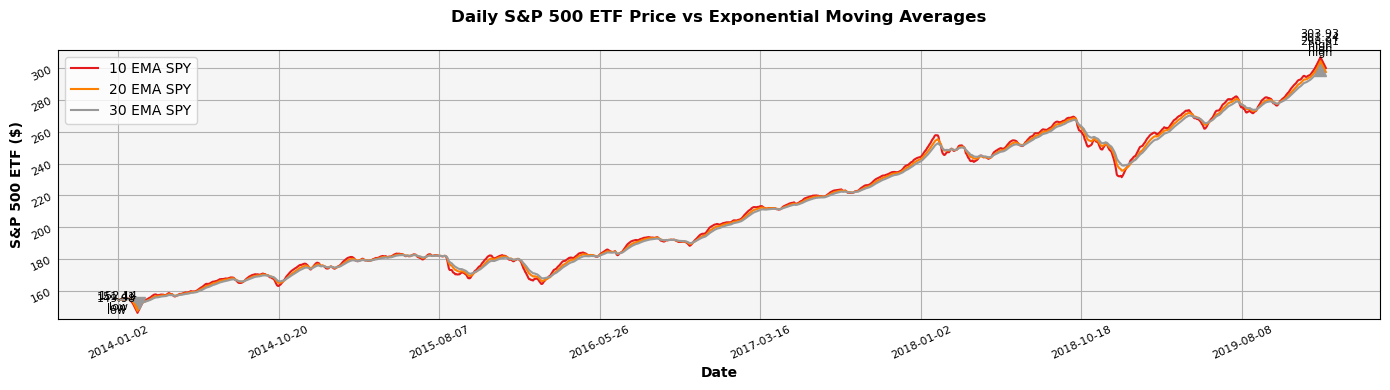

In [7]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10 EMA SPY', '20 EMA SPY', '30 EMA SPY'], title='Daily S&P 500 ETF Price vs Exponential Moving Averages')

In [8]:
n_train = int( len(df) * 0.7)

df_train = df[:n_train]
df_test = df[n_train:]

# re index 

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
df_train = trade.risk_free_buy_and_hold(df_train)
df_test = trade.risk_free_buy_and_hold(df_test)

In [10]:
_, best_window_bb, best_sigma_bb, best_drop_lim_bb = opt.cross_val_bollinger_band_strategy(df_train)
_, best_window_momentum, best_sigma_momentum = opt.cross_val_momentum_strategy(df_train)

Best window:  20
Best sigma:  1
Best drop limit:  -0.01
Best window: 10
Best sigma: 0


In [11]:
df_train = trade.bollinger_band_strategy(df_train, drop_lim=best_drop_lim_bb, window=best_window_bb, sigma=best_sigma_bb)
df_train = trade.momentum_strategy(df_train, window=best_window_momentum, sigma=best_sigma_momentum)

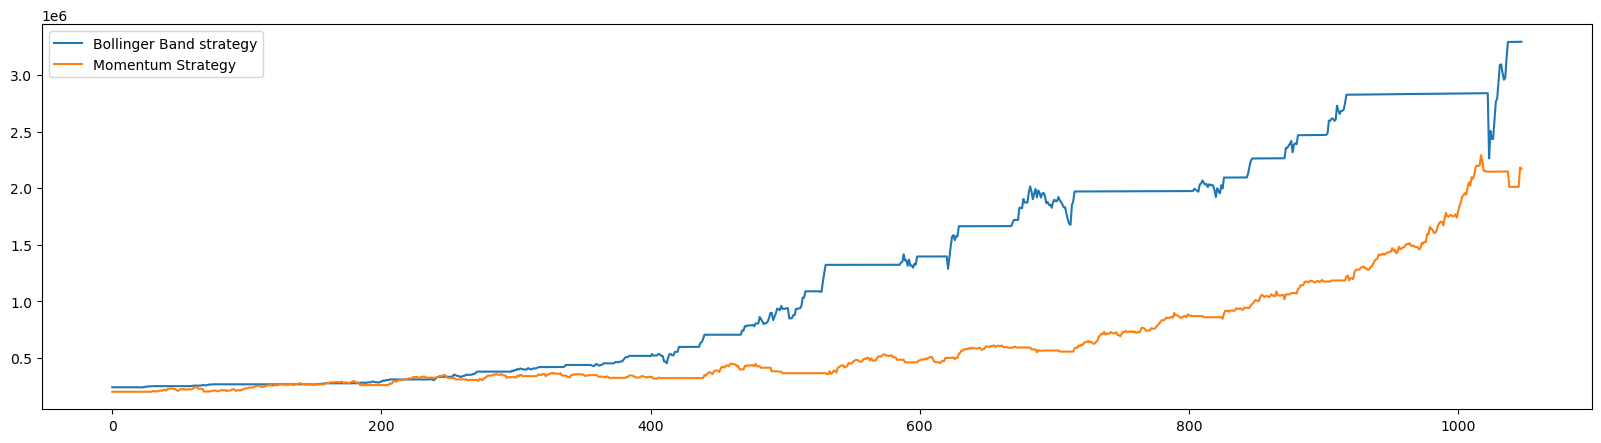

In [90]:
plt.plot(df_train['Account BB'] /5 + 2*(10**5), label = 'Bollinger Band strategy')
plt.plot(df_train['Account Momentum'], label='Momentum Strategy')
plt.legend()

In [71]:
def plot_margin(df, strategy = 'BB', leverage = 5):
    """ 
    Plot the margins account value * leverage

    Args:
        df (pd.DataFrame): data frame with account values
        strategy (str): specifies the strategy to plot
        leverage (int): specifies the leverage used in the strategy

    """
    
    account = f'Account {strategy}'
    signal = f'Signal {strategy}'
    theta = f'Theta {strategy}'
    
    plt.rcParams['figure.figsize'] = (20,5)
    plt.fill_between(x = df.index,
                     y1 = leverage * df[account],
                     y2 = - leverage * df[account],
                     color = 'purple',
                     alpha = 0.2,
                     label = '$[ - V_t \cdot L, V_t \cdot L]$')
    
    plt.plot(df[theta], label = '$\\theta_t$')
    
    mask_buy = df[signal] == 1
    mask_sell = df[signal] == -1

    plt.scatter(df[mask_buy].index, 
                df[mask_buy][theta], 
                marker='^',
                color = 'green',
                label = 'Buy / Short Close',
                s=15,
                alpha = 0.5)
    
    plt.scatter(df[mask_sell].index, 
                df[mask_sell][theta], 
                marker='v',
                color = 'red',
                label = 'Sell / Short',
                s=15,
                alpha = 0.5)
    
    plt.legend()
    plt.show()
    
    
    

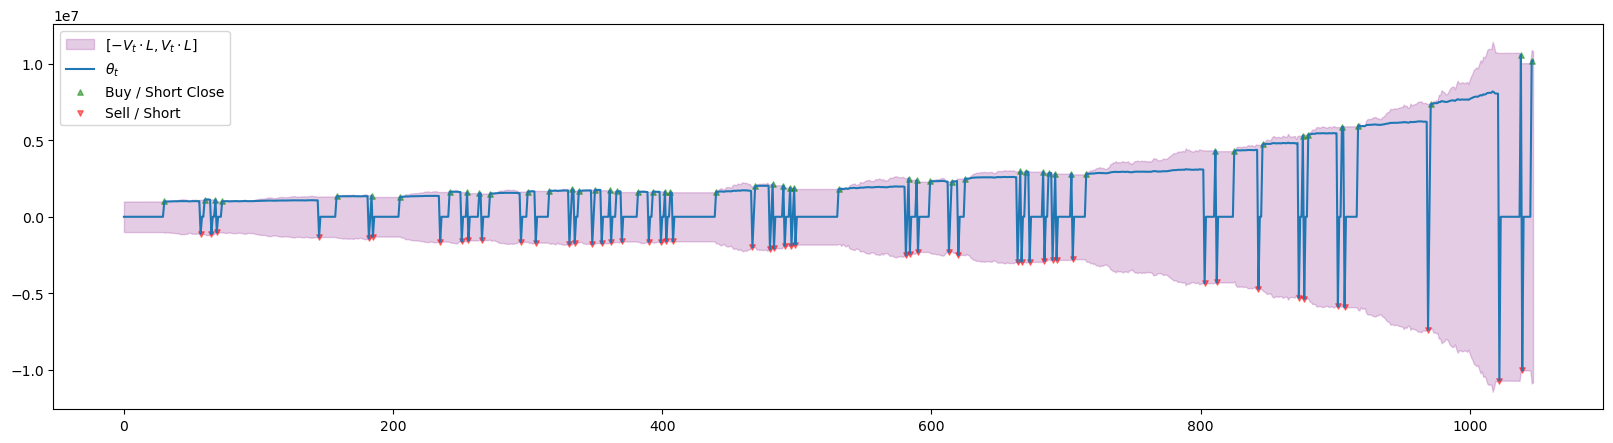

In [72]:
plot_margin(df_train, strategy='Momentum')

In [34]:
def turnover_dollars(df, strategy = 'BB'):
    """
    Calculates the turnover in dollars.
    """
    return df[f'Theta {strategy}'].diff().abs().sum()

turnover_dollars(df_train)

437260734.9050659

In [40]:
def turnover_units(df, strategy = 'BB'):
    """
    Calculates the turnover in units.
    """
    theta = f'Theta {strategy}'
    return np.sum([ abs( df[theta][i+1] / df['SPY'][i+1] - df[theta][i] / df['SPY'][i] ) for i in range(len(df)-1)]) 


In [41]:
def pnl_series(df, strategy = 'BB', leverage = 5):
    """
    Creates a total PnL series for the strategies, where we assume that unused 
    capital will be put in a money-market and grow at the same risk-free rate,
    i.e., the value of your account changes by the trading PnL (∆V ) 
    and the change in the growth of the money-market capital account (∆V cap).
    """
    theta = f'Theta {strategy}'
    account = f'Account {strategy}'
    
    delta_v = df['Excess Return'] * df[theta]

    M = df[theta].abs() / leverage
    delta_vcap = (df[account] - M) * df['EFFR']

    pnl = delta_v + delta_vcap
    df[f'PnL {strategy}'] = pnl
    df[f'V {strategy}'] = delta_v
    df[f'V Cap {strategy}'] = delta_vcap

    return pnl, delta_v, delta_vcap, df


In [42]:
pnl_momentum, delta_v_momentum, delta_vcap_momentum, _ = pnl_series(df_train, strategy='Momentum')

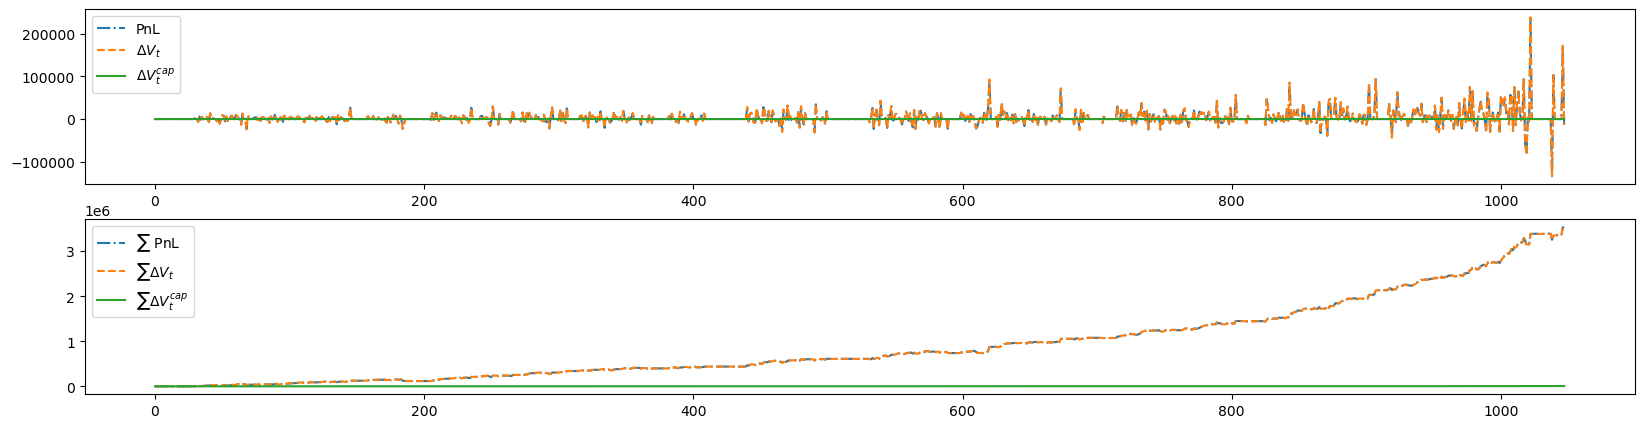

In [77]:
def plot_delta_V(pnl, delta_v, delta_vcap):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(pnl, 
            linestyle = '-.',
            label = 'PnL')
    ax[0].plot(delta_v, 
            linestyle = '--',
            label = '$\Delta V_t$')
    ax[0].plot(delta_vcap, label = '$\Delta V_t^{cap}$')

    ax[0].legend()

    
    ax[1].plot(pnl.cumsum(), 
            linestyle = '-.',
            label = '$\sum$ PnL')
    ax[1].plot(delta_v.cumsum(), 
            linestyle = '--',
            label = '$\sum \Delta V_t$')
    ax[1].plot(delta_vcap.cumsum(), label = '$\sum \Delta V_t^{cap}$')

    ax[1].legend()

    

plot_delta_V(pnl_momentum, delta_v_momentum, delta_vcap_momentum)


In [ ]:
# TODO create plot 

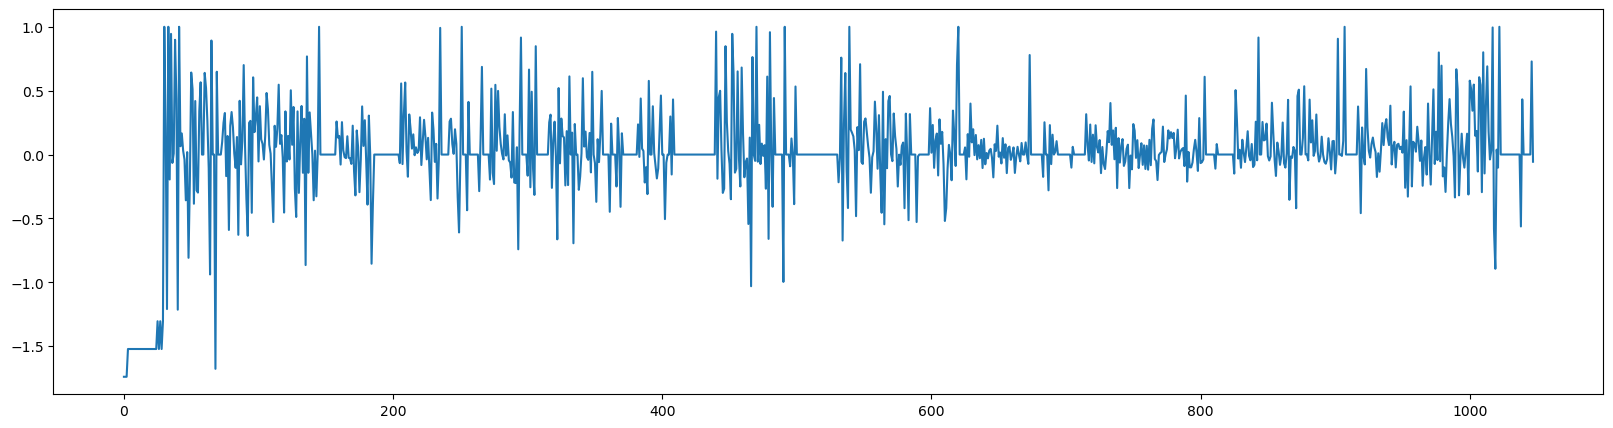

In [57]:
plt.plot(pnl_momentum / (pnl_momentum.cummax() - 1) )

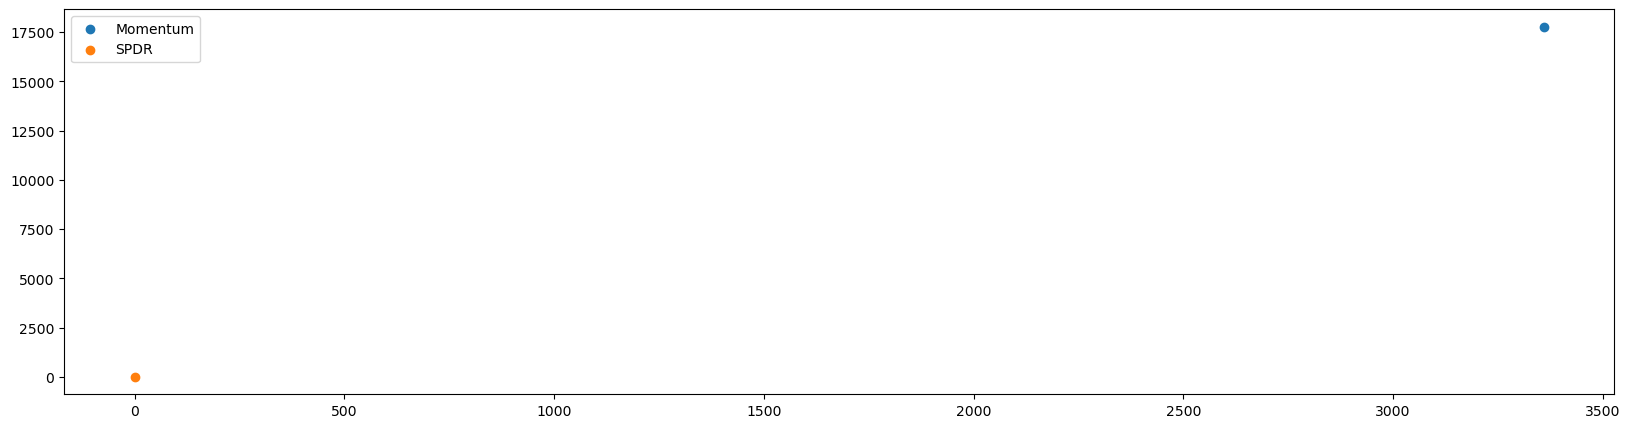

In [88]:
plt.scatter(pnl_momentum.mean(), pnl_momentum.std(), label='Momentum')
plt.scatter(df_train['Excess Return'].mean(), df_train['Excess Return'].std(), label = 'SPDR')

plt.legend(loc='best')
plt.show()